# Halbüberwachtes Lernen (engl. Semi-Supervised Learning)

Dieses Notebook ist Teil des Projekts [EmbedML](https://hahn-schickard.gitbook.io/embedml) und basiert auf den Inhalten des Kapitels [Halbüberwachtes Lernen (engl. Semi-Supervised Learning)](https://hahn-schickard.gitbook.io/embedml/2_ml/2.6_halbueberwachtes_lernen). Es ist auf [Colab](https://colab.research.google.com/drive/1t2Fd31oUw3iGYEfxePokLX1JWBnxjn1I?usp=sharing) und im [GitHub-Repository von Hahn-Schickard](https://github.com/Hahn-Schickard/EmbedML/blob/master/src/Halbueberwachtes_Lernen.ipynb) zu finden.

Installation der benötigten Bibliotheken in den angegebenen Versionen.

In [1]:
!pip install tensorflow==2.17.1 numpy==1.26.4 matplotlib==3.8.0 scikit-learn==1.5.2 > /dev/null 2>&1

Das System kann den angegebenen Pfad nicht finden.


Laden der benötigten Bibliotheken.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist

## Self-Training


Laden des MNIST-Datensatzes.<br>
Der Datensatz enthält 60.000 Trainingsbilder und -label, sowie 10.000 Testbilder und -label.

In [3]:
(X, y), (X_test, y_test) = mnist.load_data()

print(f"Format der Trainingsdaten: {X.shape}")
print(f"Format der Testdaten: {X_test.shape}")

Format der Trainingsdaten: (60000, 28, 28)
Format der Testdaten: (10000, 28, 28)


Umformen und Normalisieren der Daten.<br>
Die Bilder werden aus der zweidimensionalen Darstellung in eine eindimensionale Darstellung überführt und später so dem neuronalen Netz übergeben.

In [4]:
print(f"Format der Daten vor der Umformung: {X.shape} - Min-Wert: {np.min(X)} - Max-Wert: {np.max(X)}")

X = X.reshape((60000, 28 * 28)).astype('float32') / 255
X_test = X_test.reshape((10000, 28 * 28)).astype('float32') / 255

print(f"Format der Daten nach der Umformung: {X.shape} - Min-Wert: {np.min(X)} - Max-Wert: {np.max(X)}")

Format der Daten vor der Umformung: (60000, 28, 28) - Min-Wert: 0 - Max-Wert: 255
Format der Daten nach der Umformung: (60000, 784) - Min-Wert: 0.0 - Max-Wert: 1.0


Aufteilen der Daten in gelabelte und ungelabelte. Da Semi-Supervised Learning angewendet werden soll, wird für die ungelabelten Daten kein Label benötigt.<br>
Hier verwenden wir nur 10% der Daten als gelabelte Daten und von 90% der Daten sollen die Label automatisiert ermittelt werden.

In [5]:
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.9, random_state=42)

print(f"Format der gelabelten Daten: {X_labeled.shape}")
print(f"Format der ungelabelten Daten: {X_unlabeled.shape}")

Format der gelabelten Daten: (6000, 784)
Format der ungelabelten Daten: (54000, 784)


Definition eines kleinen Klassifikationsmodells

In [6]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(784,)),  #28*28
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                50240     
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


Kompilieren des Modells

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Durchführung von 5 Iteratrion des Self-Trainings mit ungelabelen Daten.<br>
Im Folgenden werden die einzelnen Schritte einer Iteration beschrieben:<br>
1. Das Modell wird im ersten Schritt mit den gelabelten Daten trainiert.
2. Anschließend werden für die ungelabelten Daten die möglichen Label durch das Modell ermittelt.
3. Ist die Vorhersage gut genug werden die jeweiligen Daten den gelabelten Daten hinzugefügt.
4. Im letzten Schritt einer Iteration wird die Genauigkeit des Modells auf den Testdaten ermittelt.

In [8]:
for self_iter in range(5):
    print(f'Iteration: {self_iter+1} - Anzahl Trainingsdaten: {len(X_labeled)}\n')
    # Training mit gelabelten Daten
    model.fit(X_labeled, y_labeled, epochs=5, batch_size=128, validation_split=0.2, verbose=0)
    # Vorhersagen auf unlabeled Daten
    print(f'\nIteration: {self_iter+1} - Anzahl ungelabelte Daten: {len(X_unlabeled)}\n')
    pseudo_labels = model.predict(X_unlabeled)
    # Auswahl der zuverlässigsten Vorhersagen
    confident_predictions = np.max(pseudo_labels, axis=1) > 0.8
    # Hinzufügen der zuverlässigen Vorhersagen zu den gelabelten Daten
    X_labeled = np.concatenate([X_labeled, X_unlabeled[confident_predictions]])
    y_labeled = np.concatenate([y_labeled, np.argmax(pseudo_labels[confident_predictions], axis=1)])

    # Entfernen von Daten aus X_unlabeled, die zu X_labeled hinzugefügt werden
    X_unlabeled = X_unlabeled[~confident_predictions]

    # Evaluierung auf Testdaten
    test_accuracy = accuracy_score(y_test, np.argmax(model.predict(X_test), axis=1))
    print(f'Iteration: {self_iter+1} - Testgenauigkeit: {test_accuracy}\n\n')

Iteration: 1 - Anzahl Trainingsdaten: 6000


Iteration: 1 - Anzahl ungelabelte Daten: 54000

313/313 [==============================] - 0s 1ms/step
Iteration: 1 - Testgenauigkeit: 0.9097


Iteration: 2 - Anzahl Trainingsdaten: 45627


Iteration: 2 - Anzahl ungelabelte Daten: 14373

313/313 [==============================] - 0s 1ms/step
Iteration: 2 - Testgenauigkeit: 0.928


Iteration: 3 - Anzahl Trainingsdaten: 54662


Iteration: 3 - Anzahl ungelabelte Daten: 5338

313/313 [==============================] - 0s 1ms/step
Iteration: 3 - Testgenauigkeit: 0.9326


Iteration: 4 - Anzahl Trainingsdaten: 56987


Iteration: 4 - Anzahl ungelabelte Daten: 3013

313/313 [==============================] - 0s 1ms/step
Iteration: 4 - Testgenauigkeit: 0.9355


Iteration: 5 - Anzahl Trainingsdaten: 58036


Iteration: 5 - Anzahl ungelabelte Daten: 1964

313/313 [==============================] - 0s 1ms/step
Iteration: 5 - Testgenauigkeit: 0.9351




## Co-Training


Laden des MNIST-Datensatzes.<br>
Der Datensatz enthält 60.000 Trainingsbilder und -label, sowie 10.000 Testbilder und -label.

In [9]:
(X, y), (X_test, y_test) = mnist.load_data()

print(f"Format der Trainingsdaten: {X.shape}")
print(f"Format der Testdaten: {X_test.shape}")

Format der Trainingsdaten: (60000, 28, 28)
Format der Testdaten: (10000, 28, 28)


Umformen und Normalisieren der Daten.

In [10]:
print(f"Format der Daten vor der Umformung: {X.shape} - Min-Wert: {np.min(X)} - Max-Wert: {np.max(X)}")

X = X.astype('float32') / 255
X_test = X_test.astype('float32') / 255

print(f"Format der Daten nach der Umformung: {X.shape} - Min-Wert: {np.min(X)} - Max-Wert: {np.max(X)}")

Format der Daten vor der Umformung: (60000, 28, 28) - Min-Wert: 0 - Max-Wert: 255
Format der Daten nach der Umformung: (60000, 28, 28) - Min-Wert: 0.0 - Max-Wert: 1.0


Aufteilen der Daten in gelabelte und ungelabelte. Da Semi-Supervised Learning angewendet werden soll, wird für die ungelabelten Daten kein Label benötigt.<br>
Hier verwenden wir nur 10% der Daten als gelabelte Daten und von 90% der Daten sollen die Label automatisiert ermittelt werden.

In [11]:
X_labeled, X_unlabeled, y_labeled, _ = train_test_split(X, y, test_size=0.9, random_state=42)

Beim Co-Training werden mehrere Modelle unabhängig voneinander trainiert, auf verschiedenen Teilmengen der Daten.<br>
In diesem Beispiel werden zwei neuronale Netze trainiert. Eines davon erhält lediglich die linke Hälfte des Bildes, das andere die rechte Hälfte.<br>
Die Bilder (gelabelt, ungelabelt und Test) werden hier geteilt und aus der zweidimensionalen Darstellung in eine eindimensionale Darstellung überführt, um es später so den neuronalen Netzen zu übergeben.

In [12]:
# Bilder in linke und rechte Hälfte teilen
X_labeled_left_half = X_labeled[:, :, :14].reshape((-1, 14 * 28))
X_labeled_right_half = X_labeled[:, :, 14:].reshape((-1, 14 * 28))

X_unlabeled_left_half = X_unlabeled[:, :, :14].reshape((-1, 14 * 28))
X_unlabeled_right_half = X_unlabeled[:, :, 14:].reshape((-1, 14 * 28))

X_test_left = X_test[:, :, :14].reshape((-1, 14 * 28))
X_test_right = X_test[:, :, 14:].reshape((-1, 14 * 28))

print(f"Format der Daten (linke Bildhälfte): {X_labeled_left_half.shape}")
print(f"Format der Daten (rechte Bildhälfte): {X_labeled_right_half.shape}")

Format der Daten (linke Bildhälfte): (6000, 392)
Format der Daten (rechte Bildhälfte): (6000, 392)


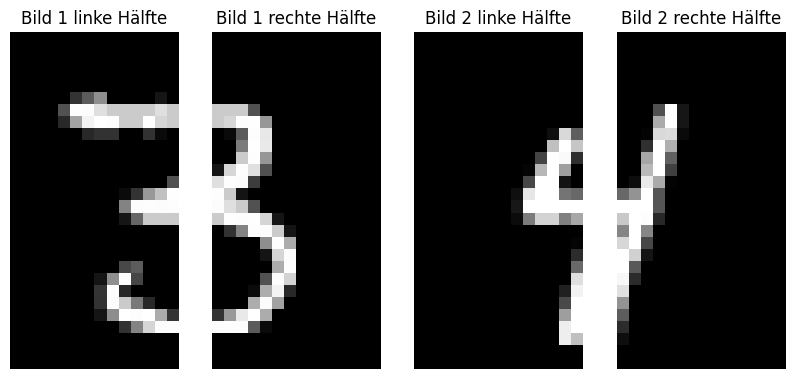

In [13]:
plt.figure(figsize=(10, 5));
plt.subplot(1, 4, 1);
plt.title('Bild 1 linke Hälfte');
plt.imshow(X_labeled_left_half[0].reshape((28, 14)), cmap='gray');
plt.axis('off');

plt.subplot(1, 4, 2);
plt.title('Bild 1 rechte Hälfte');
plt.imshow(X_labeled_right_half[0].reshape((28, 14)), cmap='gray');
plt.axis('off');

plt.subplot(1, 4, 3);
plt.title('Bild 2 linke Hälfte');
plt.imshow(X_labeled_left_half[1].reshape((28, 14)), cmap='gray');
plt.axis('off');

plt.subplot(1, 4, 4);
plt.title('Bild 2 rechte Hälfte');
plt.imshow(X_labeled_right_half[1].reshape((28, 14)), cmap='gray');
plt.axis('off');

Definition zweier kleiner Klassifikationsmodelle

In [14]:
def create_base_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

model_1 = create_base_model((14 * 28,))
model_2 = create_base_model((14 * 28,))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                25152     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 25,802
Trainable params: 25,802
Non-trainable params: 0
_________________________________________________________________


Kompilieren der Modelle

In [15]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Durchführung von 5 Iteratrion des Co-Trainings mit ungelabelen Daten.<br>
Im Folgenden werden die einzelnen Schritte einer Iteration beschrieben:<br>
1. Die Modelle werden im ersten Schritt mit den gelabelten Daten trainiert. Das eine mit der linken Hälfte, das andere mit der rechten Hälfte der Bilder.
2. Anschließend werden für die ungelabelten Daten die möglichen Label durch die Modell ermittelt.
3. Ist die Vorhersage mindestens eines Modells gut genug werden die jeweiligen Daten den gelabelten Daten hinzugefügt.
4. Im letzten Schritt einer Iteration wird die Genauigkeit der Modelle auf den Testdaten ermittelt.

In [16]:
for co_iter in range(5):

    print(f'Iteration: {co_iter+1} - Anzahl Trainingsdaten obere/untere Hälfte: {len(X_labeled_left_half)}/{len(X_labeled_right_half)}\n')
    # Training von model_1 mit gelabelten Daten (linke Hälfte)
    print(f'Iteration: {co_iter+1} - Training Model 1')
    model_1.fit(X_labeled_left_half, y_labeled, epochs=10, batch_size=128, validation_split=0.2, verbose=0)
    # Training von model_2 mit gelabelten Daten (rechte Hälfte)
    print(f'\nIteration: {co_iter+1} - Training Model 2')
    model_2.fit(X_labeled_right_half, y_labeled, epochs=10, batch_size=128, validation_split=0.2, verbose=0)

    print(f'\nIteration: {co_iter+1} - Anzahl ungelabelte Daten: {len(X_unlabeled_left_half)}')
    # Vorhersagen auf unlabeled Daten für beide Modelle
    pseudo_labels_1 = model_1.predict(X_unlabeled_left_half)
    pseudo_labels_2 = model_2.predict(X_unlabeled_right_half)

    # Auswahl der zuverlässigsten Vorhersagen
    confident_predictions1 = np.max(pseudo_labels_1, axis=1) > 0.95
    confident_predictions2 = np.max(pseudo_labels_2, axis=1) > 0.95

    # Daten und pseudo label erhalten, wenn beide Modelle zuversichtlich sind
    confident_pred_and = confident_predictions1 & confident_predictions2
    same_labels_and = np.argmax(pseudo_labels_1[confident_pred_and], axis=1) == np.argmax(pseudo_labels_2[confident_pred_and], axis=1)
    X_unlabeled_left_half_and = X_unlabeled_left_half[confident_pred_and][same_labels_and]
    X_unlabeled_right_half_and = X_unlabeled_right_half[confident_pred_and][same_labels_and]
    pseudo_labels_and = np.argmax(pseudo_labels_1[confident_pred_and], axis=1)[same_labels_and]

    # Daten und pseudo label erhalten, wenn ein Modell zuversichtlich ist
    confident_pred_dif = confident_predictions1 != confident_predictions2
    X_unlabeled_left_half_1_dif = X_unlabeled_left_half[confident_predictions1&confident_pred_dif]
    X_unlabeled_right_half_1_dif = X_unlabeled_right_half[confident_predictions1&confident_pred_dif]
    pseudo_labels_1_dif = np.argmax(pseudo_labels_1[confident_predictions1&confident_pred_dif], axis=1)
    X_unlabeled_left_half_2_dif = X_unlabeled_left_half[confident_predictions2&confident_pred_dif]
    X_unlabeled_right_half_2_dif = X_unlabeled_right_half[confident_predictions2&confident_pred_dif]
    pseudo_labels_2_dif = np.argmax(pseudo_labels_2[confident_predictions2&confident_pred_dif], axis=1)

	# Kombinieren der zuversichtlichen Vorhersagen
    combined_confident_preds = confident_pred_and | confident_pred_dif

    # Hinzufügen der zuverlässigen Vorhersagen zu den gelabelten Daten
    X_labeled_left_half = np.concatenate([X_labeled_left_half, X_unlabeled_left_half_and, X_unlabeled_left_half_1_dif, X_unlabeled_left_half_2_dif])
    X_labeled_right_half = np.concatenate([X_labeled_right_half, X_unlabeled_right_half_and, X_unlabeled_right_half_1_dif, X_unlabeled_right_half_2_dif])
    y_labeled = np.concatenate([y_labeled, pseudo_labels_and, pseudo_labels_1_dif, pseudo_labels_2_dif])

    # Entfernen von Daten aus X_unlabeled, die zu X_labeled hinzugefügt werden
    X_unlabeled_left_half = X_unlabeled_left_half[~combined_confident_preds]
    X_unlabeled_right_half = X_unlabeled_right_half[~combined_confident_preds]

    # Evaluierung auf Testdaten
    test_accuracy_model_1 = accuracy_score(y_test, np.argmax(model_1.predict(X_test_left), axis=1))
    test_accuracy_model_2 = accuracy_score(y_test, np.argmax(model_2.predict(X_test_right), axis=1))

    print(f'Iteration: {co_iter+1} - Testgenauigkeit Model 1: {test_accuracy_model_1}')
    print(f'Iteration: {co_iter+1} - Testgenauigkeit Model 2: {test_accuracy_model_2}\n\n')

    # Wenn weniger als 100 unlabeled Datenpunkte vorhanden sind, Schleife beenden
    if len(X_unlabeled_left_half) < 100:
        break

Iteration: 1 - Anzahl Trainingsdaten obere/untere Hälfte: 6000/6000

Iteration: 1 - Training Model 1

Iteration: 1 - Training Model 2

Iteration: 1 - Anzahl ungelabelte Daten: 54000
313/313 [==============================] - 0s 1ms/step
Iteration: 1 - Testgenauigkeit Model 1: 0.8612
Iteration: 1 - Testgenauigkeit Model 2: 0.8554


Iteration: 2 - Anzahl Trainingsdaten obere/untere Hälfte: 31461/31461

Iteration: 2 - Training Model 1

Iteration: 2 - Training Model 2

Iteration: 2 - Anzahl ungelabelte Daten: 28493
313/313 [==============================] - 0s 1ms/step
Iteration: 2 - Testgenauigkeit Model 1: 0.8961
Iteration: 2 - Testgenauigkeit Model 2: 0.8871


Iteration: 3 - Anzahl Trainingsdaten obere/untere Hälfte: 46114/46114

Iteration: 3 - Training Model 1

Iteration: 3 - Training Model 2

Iteration: 3 - Anzahl ungelabelte Daten: 13762
313/313 [==============================] - 1s 2ms/step
Iteration: 3 - Testgenauigkeit Model 1: 0.9078
Iteration: 3 - Testgenauigkeit Model 2: 0.8929